In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
sns.set()

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [3]:
df = pd.read_csv("ad_click_dataset.csv")

In [4]:
df.head()

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,User670,22.0,NaN,Desktop,Top,Shopping,Afternoon,1
1,3044,User3044,NaN,Male,Desktop,Top,NaN,NaN,1
2,5912,User5912,41.0,Non-Binary,NaN,Side,Education,Night,1
3,5418,User5418,34.0,Male,NaN,NaN,Entertainment,Evening,1
4,9452,User9452,39.0,Non-Binary,NaN,NaN,Social Media,Morning,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                10000 non-null  int64  
 1   full_name         10000 non-null  object 
 2   age               5234 non-null   float64
 3   gender            5307 non-null   object 
 4   device_type       8000 non-null   object 
 5   ad_position       8000 non-null   object 
 6   browsing_history  5218 non-null   object 
 7   time_of_day       8000 non-null   object 
 8   click             10000 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 703.2+ KB


In [6]:
df.duplicated().sum()

2853

In [7]:
df = df.drop_duplicates()

In [8]:
df.isnull().sum()

id                     0
full_name              0
age                 3476
gender              3400
device_type         1728
ad_position         1743
browsing_history    3480
time_of_day         1712
click                  0
dtype: int64

Text(0, 0.5, 'Frequency')

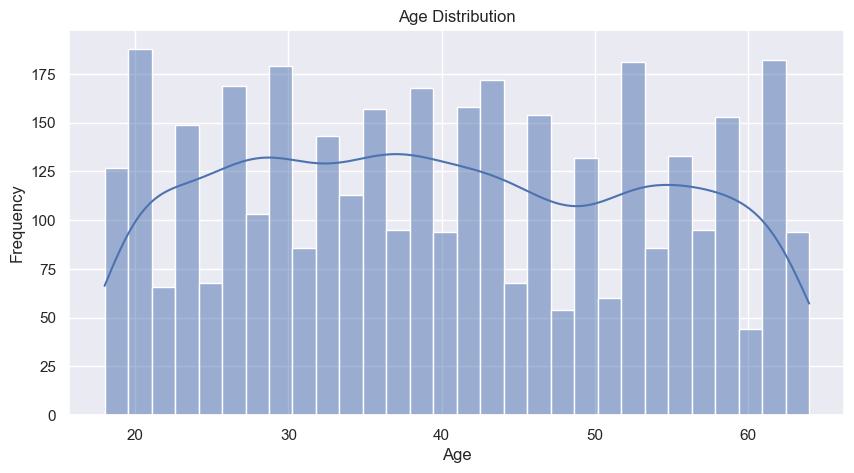

In [9]:
plt.figure(figsize=(10,5))
sns.histplot(df['age'],bins=30, kde=True)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")

Text(0, 0.5, 'Count')

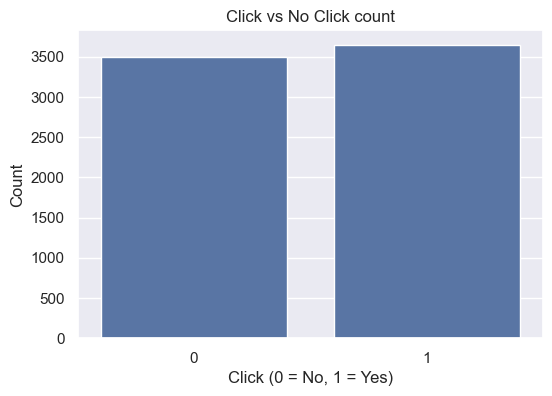

In [10]:
plt.figure(figsize=(6,4))
sns.countplot(x='click',data=df)
plt.title("Click vs No Click count")
plt.xlabel("Click (0 = No, 1 = Yes)")
plt.ylabel("Count")

In [11]:
X = df.drop(['click','full_name','id'],axis=1)
y = df['click']

In [12]:
num_features = ['age']
cat_features = ['gender','device_type','ad_position','browsing_history','time_of_day']

In [13]:
num_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy='constant',fill_value='unknown')),
     ('onehot',OneHotEncoder(handle_unknown='ignore'))
])

In [14]:
preprocessor = ColumnTransformer([
    ('num',num_pipeline,num_features),
    ('cat',cat_pipeline,cat_features)
])

In [15]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [16]:
logistic_pipeline = Pipeline([
    ('preprocess',preprocessor),
    ('regression', LogisticRegression(
        class_weight='balanced',
        solver='liblinear',
        random_state=42
    ))
])

In [17]:
logistic_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'device_type',
                                                   'ad_position',
                                                   'browsing_history',
                                                   'time_of_day'])])),
                ('regression',
                 LogisticRegression(class_weight='balanced', random_state=42,
                                    solver='liblinear'))])

In [18]:
y_pred_log = logistic_pipeline.predict(X_test)

In [19]:
print('Logistic Regression accuracy:',accuracy_score(y_test,y_pred_log))
print('confusion matrix:',confusion_matrix(y_test,y_pred_log))
print('classification report:',classification_report(y_test,y_pred_log))

Logistic Regression accuracy: 0.5951048951048951
confusion matrix: [[413 291]
 [288 438]]
classification report:               precision    recall  f1-score   support

           0       0.59      0.59      0.59       704
           1       0.60      0.60      0.60       726

    accuracy                           0.60      1430
   macro avg       0.59      0.59      0.59      1430
weighted avg       0.60      0.60      0.60      1430



In [20]:
counter = Counter(y_train)
neg,pos = counter[0],counter[1]
scale = neg/pos

In [21]:
print(f"Class distribution in y_train: {counter}")
print(f"scale_pos_weight: {scale:.2f}")

Class distribution in y_train: Counter({1: 2921, 0: 2796})
scale_pos_weight: 0.96


In [22]:
xgb_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', XGBClassifier(
        use_label_encoder=False,
        eval_metrics='logloss',
        scale_pos_weight=scale,
        random_state=42))
])

In [23]:
xgb_pipeline.fit(X_train,y_train)

C:\Users\S Sangeetha\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [11:51:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "eval_metrics", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'device_type',
                                                   'ad_position',...
                               eval_metrics='logloss', feature_types=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [24]:
y_pred=xgb_pipeline.predict(X_test)

In [25]:
print("XGBoost Accuracy:",accuracy_score(y_test,y_pred))
print("Classification report:",classification_report(y_test,y_pred))
print("Confusion_matrix:",confusion_matrix(y_test,y_pred))

XGBoost Accuracy: 0.6433566433566433
Classification report:               precision    recall  f1-score   support

           0       0.65      0.59      0.62       704
           1       0.64      0.69      0.66       726

    accuracy                           0.64      1430
   macro avg       0.64      0.64      0.64      1430
weighted avg       0.64      0.64      0.64      1430

Confusion_matrix: [[418 286]
 [224 502]]
